# Validation

Run all models with the same step inputs to visually validate that the drones do what we think they should do.

More of a sanity check for me than anything.

In [1]:
%matplotlib notebook
from notebook_quick_setup import *

Beginning notebook setup...
	Added /home/jhewers/Documents/projects/jdrones/src to path
	Imported gymnasium version 0.27.1


/home/jhewers/Documents/projects/jdrones/src/jdrones/__init__.py:7: UserWarning: 
Both NL and L are currently using a LHR coordinate system,
whilst the PB3 model is using a RHR system. This WILL cause 
issues in the future and MUST changed at some point.

  warnings.warn("""
pybullet build time: Feb  2 2023 13:13:41
/home/jhewers/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


	Imported jdrones version unknown
	Imported scipy==1.7.3, numpy==1.23.5, pandas==1.3.5
	Imported functools, collections and itertools
	Imported tqdm (standard and trange)
	Imported seaborn==0.11.2, matplotlib==3.5.1
End of notebook setup


In [2]:
dt = 1 / 240
seed = 1337

In [3]:
initial_state = State()
initial_state.pos = (0, 0, 1)
pb3_env = gymnasium.make("PyBulletDroneEnv-v0", dt=dt, initial_state=initial_state)

nl_env = gymnasium.make(
    "NonLinearDynamicModelDroneEnv-v0", dt=dt, initial_state=initial_state
)


class LinEnvUpdateWrapper(gymnasium.ActionWrapper):
    @staticmethod
    def action(action):
        return np.square(action)


l_env = gymnasium.make(
    "LinearDynamicModelDroneEnv-v0", dt=dt, initial_state=initial_state
)
l_env = LinEnvUpdateWrapper(l_env)

In [4]:
def output_to_df(output):
    dfs = [States(v).to_df(tag=k, dt=dt) for k, v in output.items()]
    return pd.concat(dfs).reset_index()


def run(env, u):
    log = collections.deque()
    obs, _ = env.reset()
    for ui in u:
        log.append(np.copy(obs))
        obs, _, term, trunc, _ = env.step(ui)
        if term or trunc:
            break
    return np.array(log)


def run_envs(u):
    return output_to_df(
        dict(
            PB3=run(pb3_env, u),
            NL=run(nl_env, u),
            L=run(l_env, u),
        )
    )


def plot_data(df):
    fig, ax = plt.subplots(3, figsize=(8, 12))
    ax = ax.flatten()
    for i, vars in enumerate(["'x','y','z'", "'phi','theta','psi'", "'vx','vy','vz'"]):
        sns.lineplot(
            data=df.query(f"variable in ({vars})"),
            x="t",
            y="value",
            hue="variable",
            style="tag",
            ax=ax[i],
        )
        ax[i].legend()

    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots(9, figsize=(8, 15))
    ax = ax.flatten()
    for i, var in enumerate(("x", "y", "z", "phi", "theta", "psi", "vx", "vy", "vz")):
        sns.lineplot(
            data=df.query(f"variable in ('{var}')"),
            x="t",
            y="value",
            hue="variable",
            style="tag",
            ax=ax[i],
            legend=False,
        )
        ax[i].set_ylabel(var)
    fig.tight_layout()
    plt.show()

## Zero Inputs

<IPython.core.display.Javascript object>


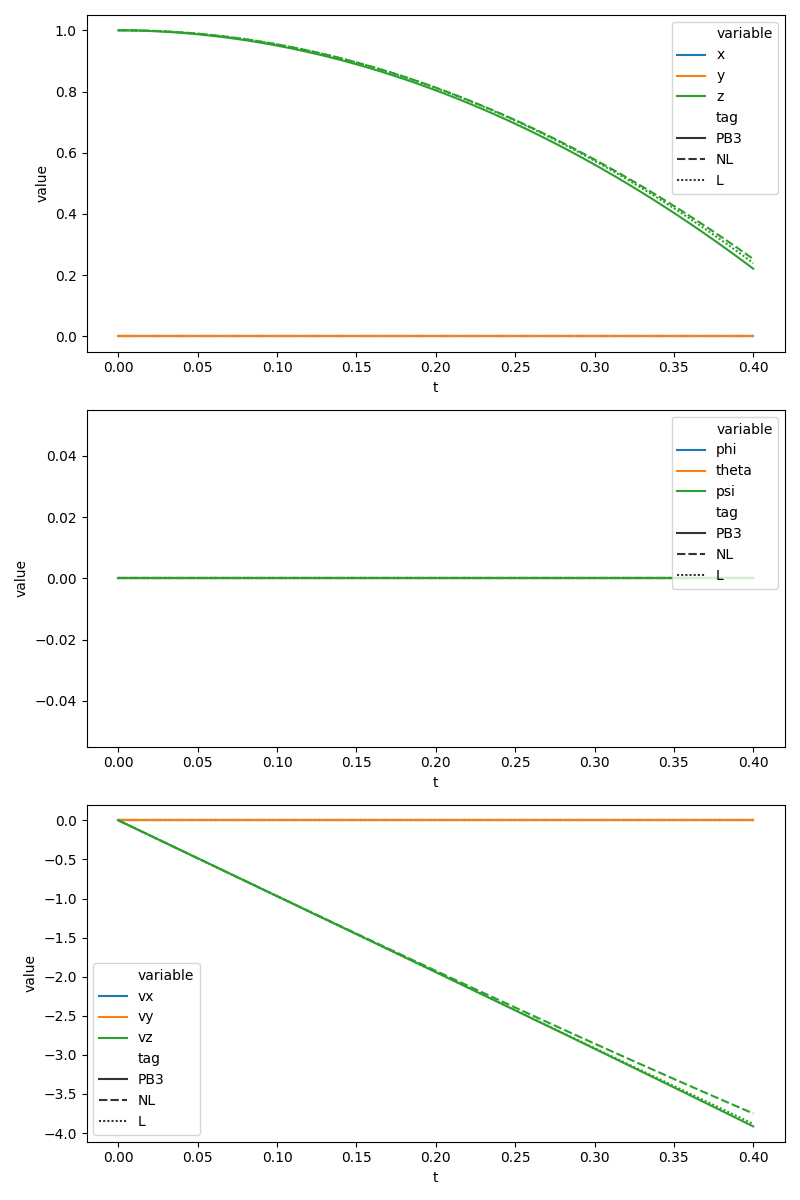

<IPython.core.display.Javascript object>


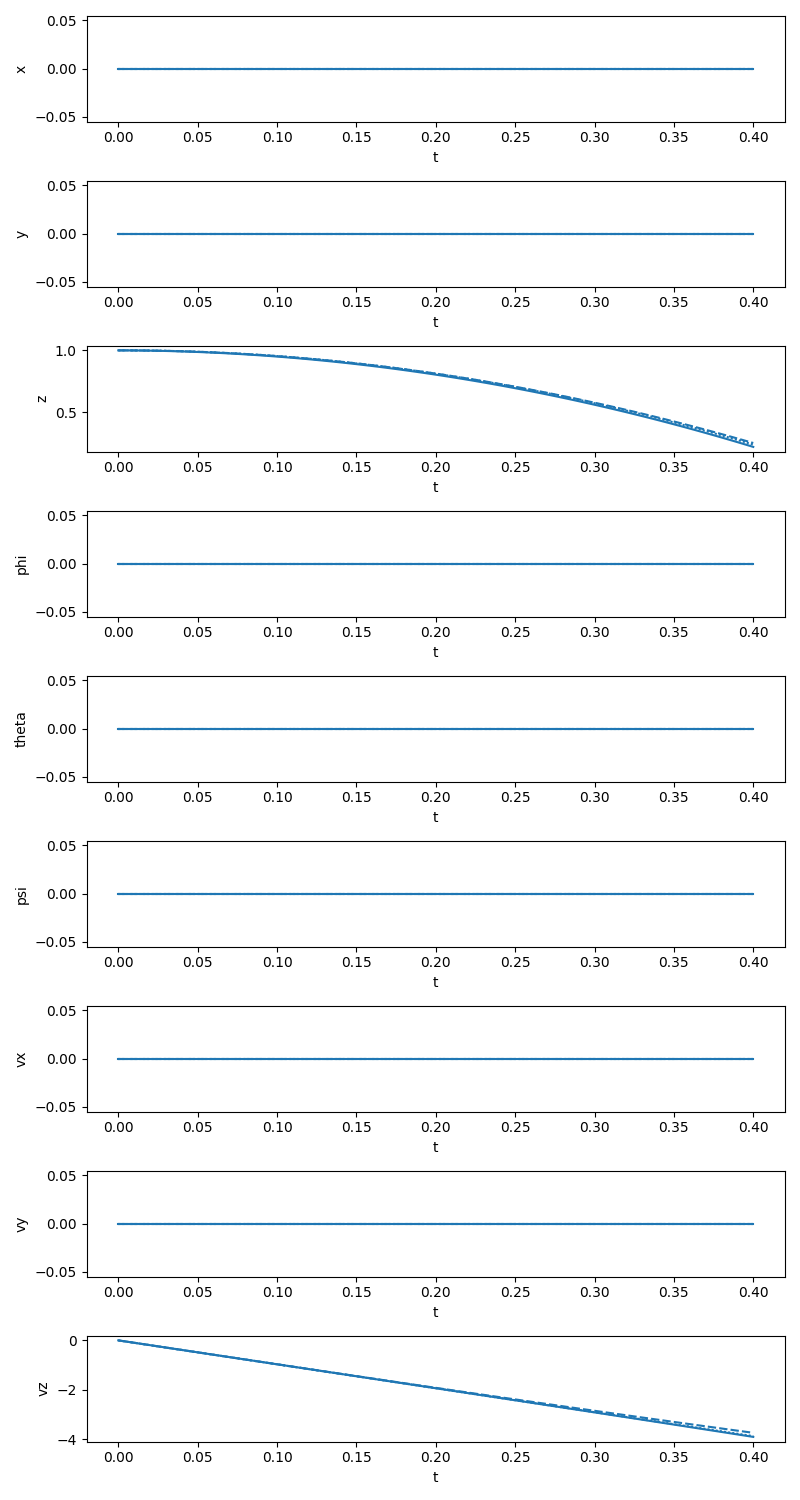

In [5]:
T = 0.4
u = np.zeros((int(T/dt),4))
out = run_envs(u)
plot_data(out)

## Positive Inputs

<IPython.core.display.Javascript object>


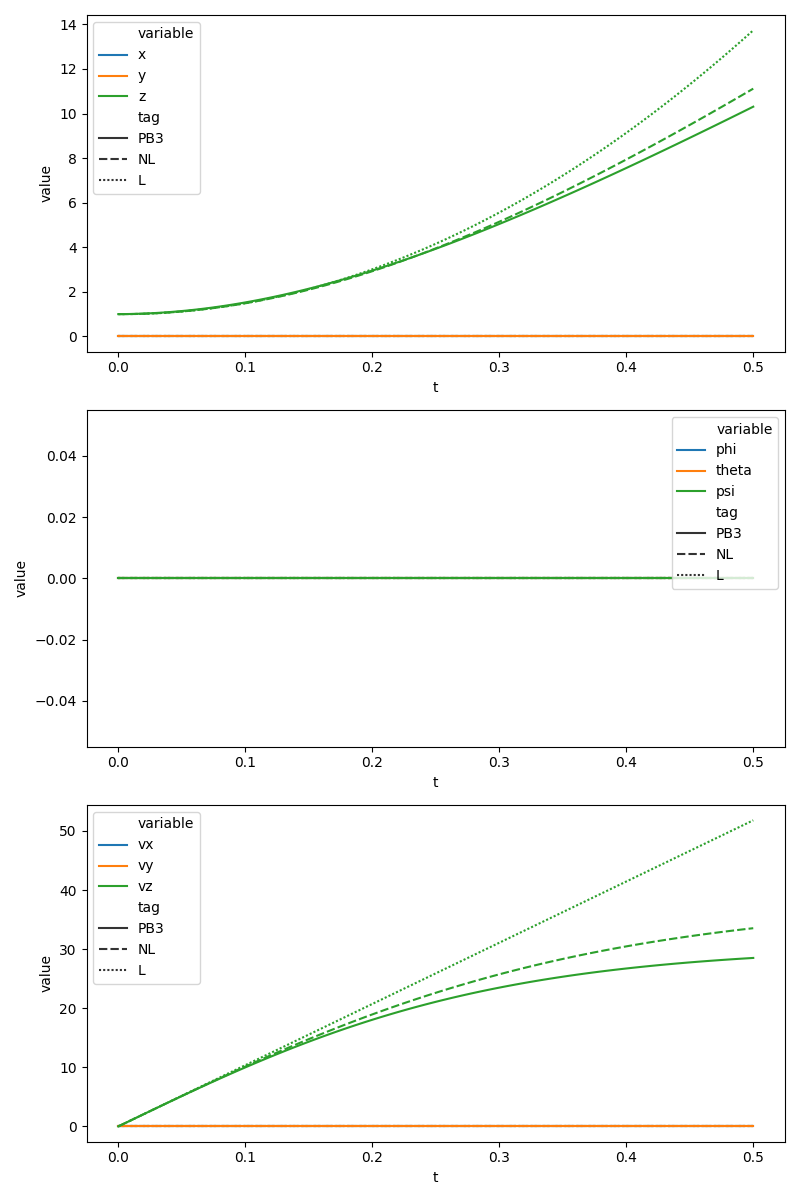

<IPython.core.display.Javascript object>


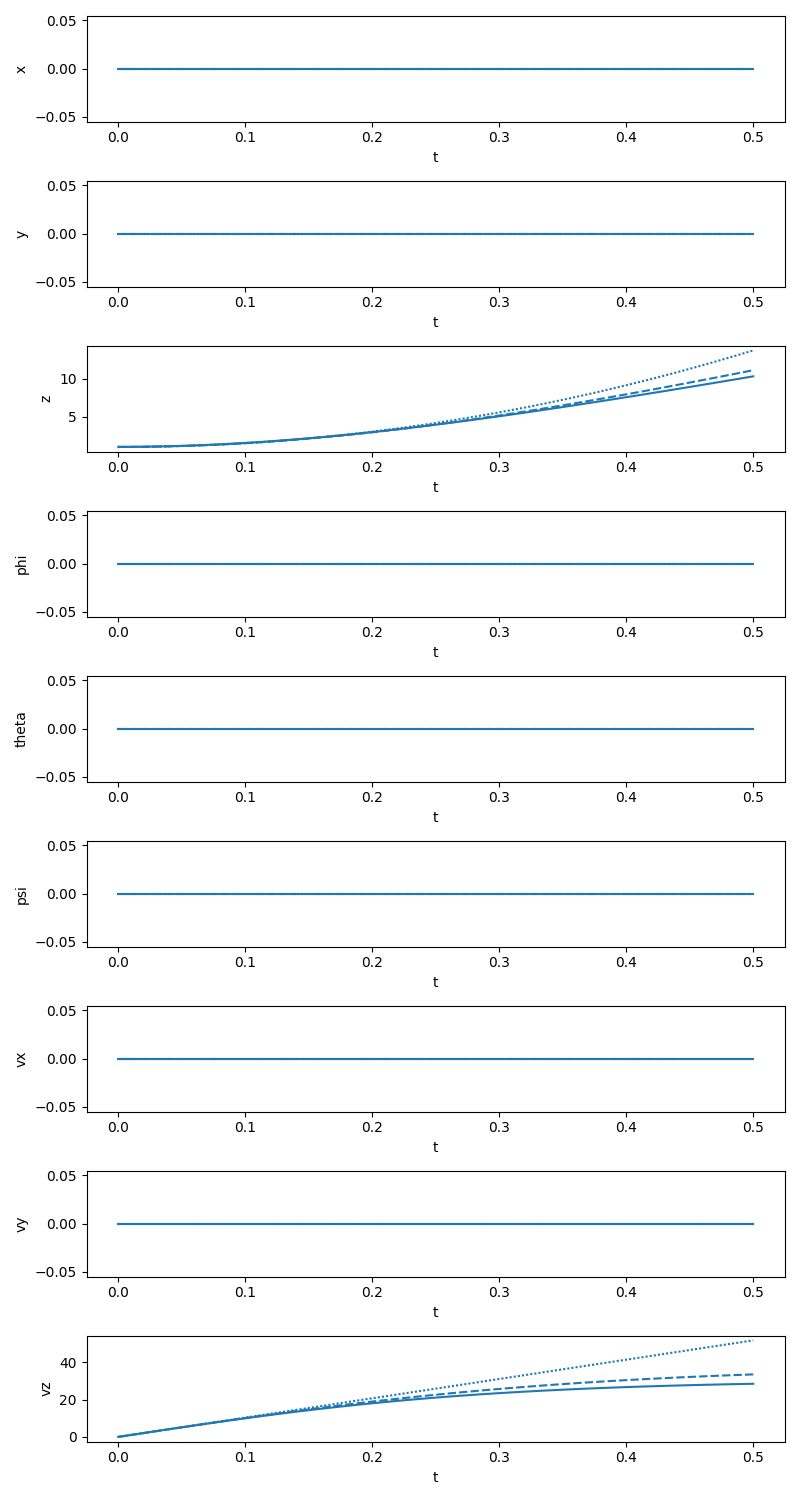

In [6]:
T = 0.5
u = np.ones((int(T/dt),4))*20
out = run_envs(u)
plot_data(out)

## Hover Input

<IPython.core.display.Javascript object>


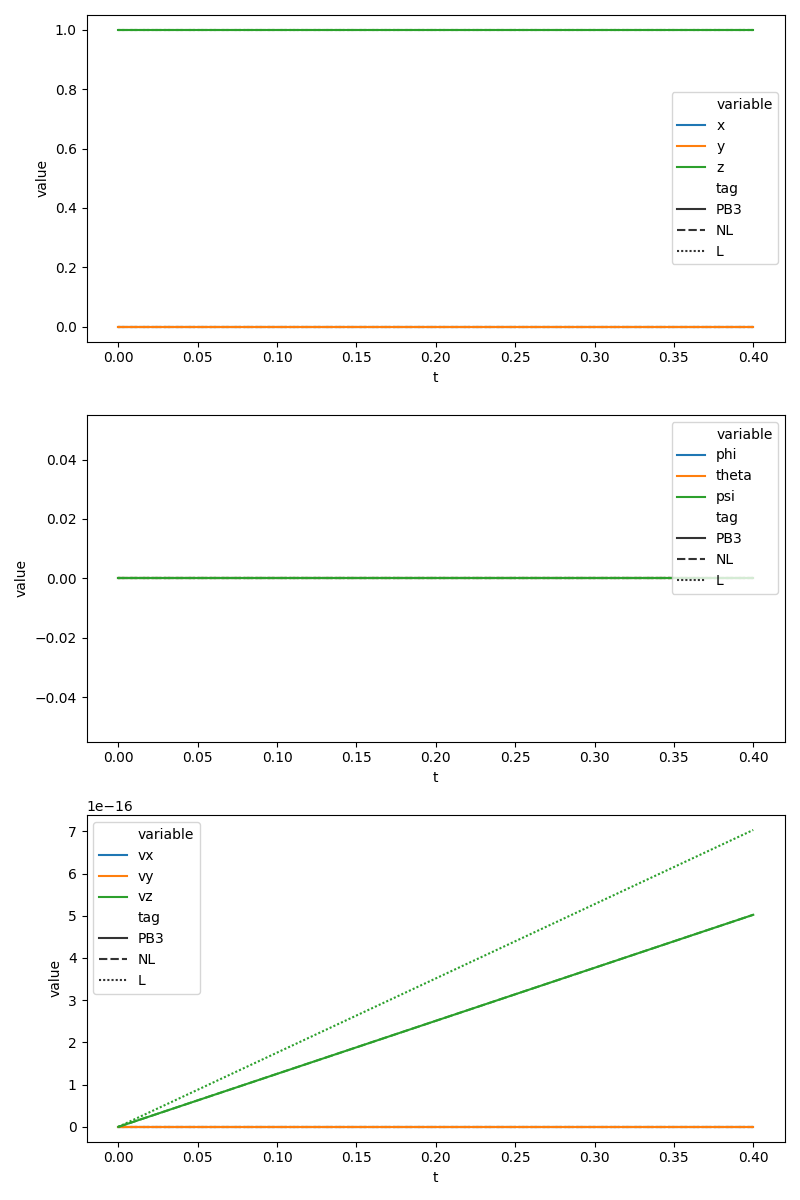

<IPython.core.display.Javascript object>


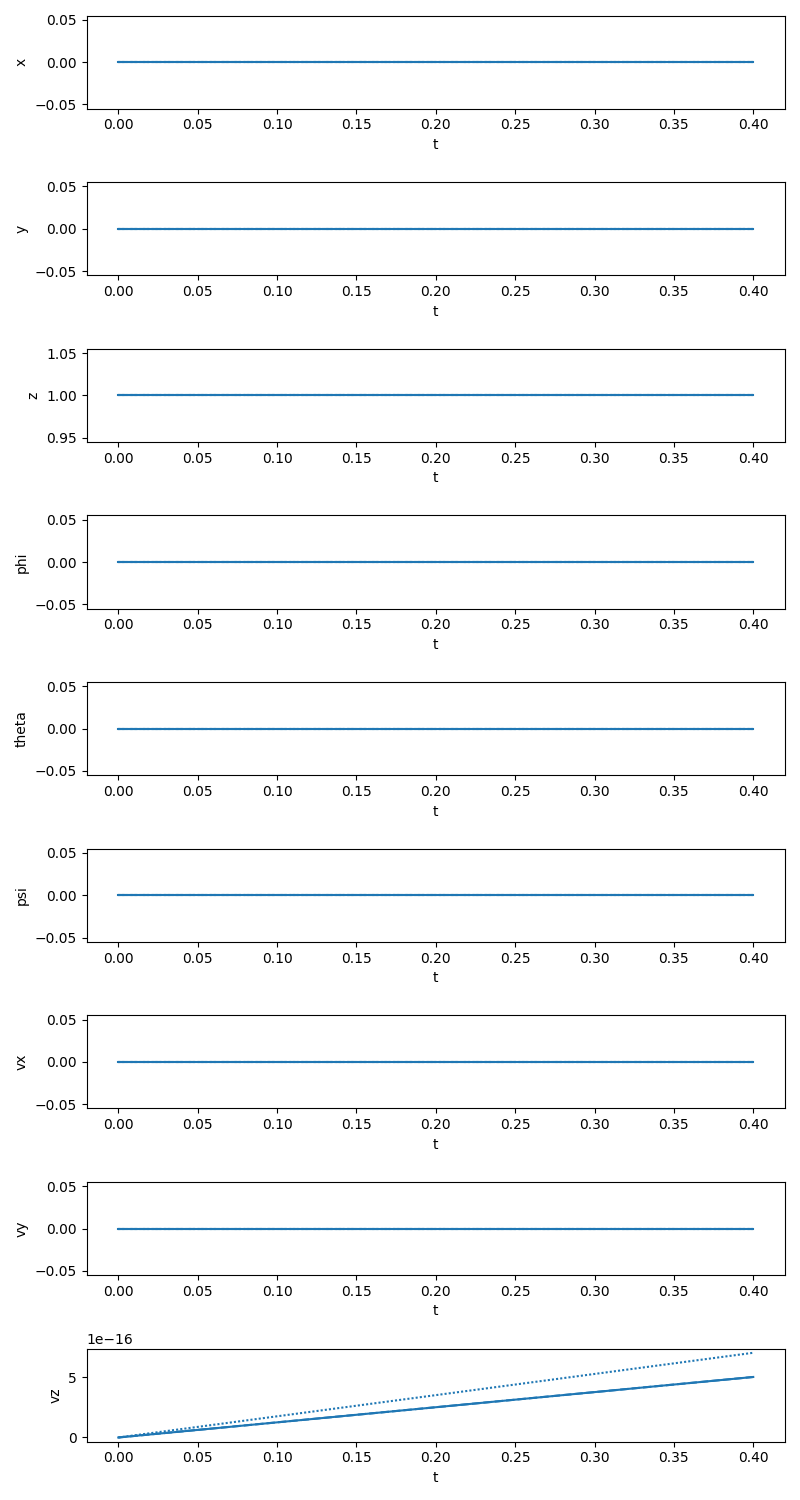

In [7]:
T = 0.4
u = np.ones((int(T/dt),4))*np.sqrt(9.81*1.4/(0.1*4))
out = run_envs(u)
plot_data(out)

## Roll Input

<IPython.core.display.Javascript object>


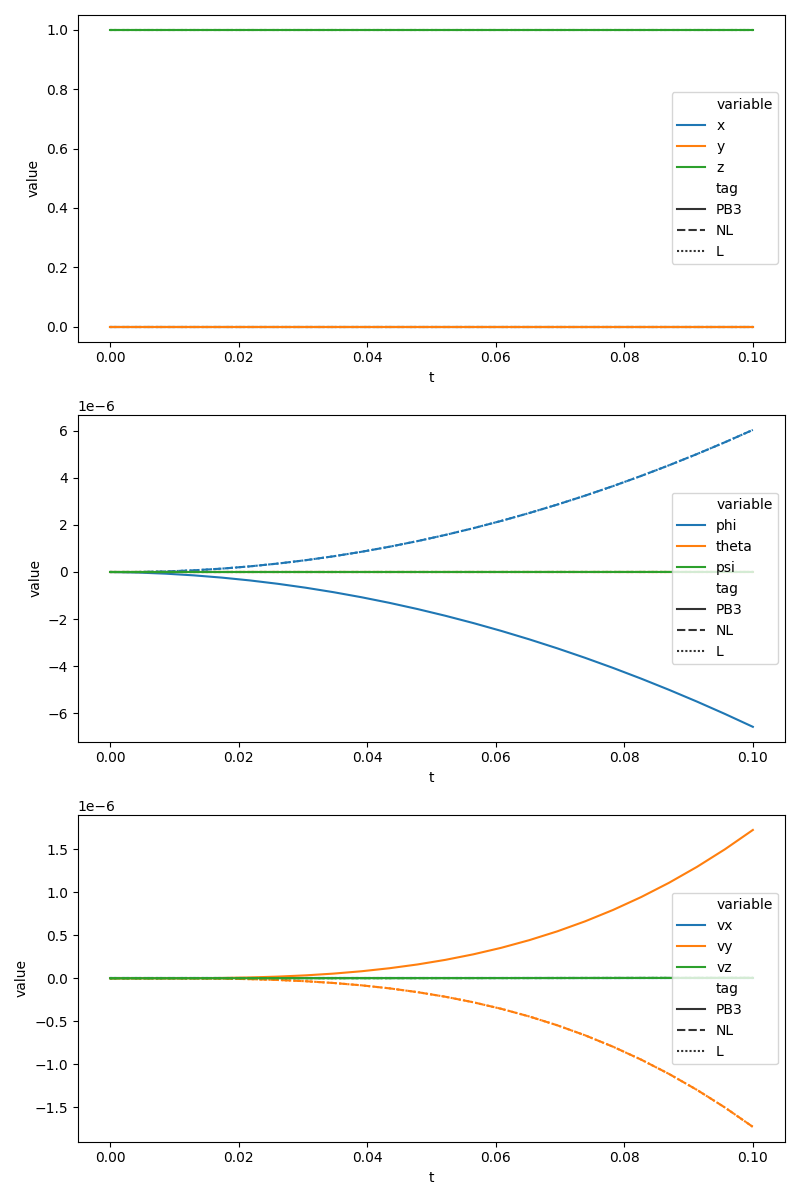

<IPython.core.display.Javascript object>


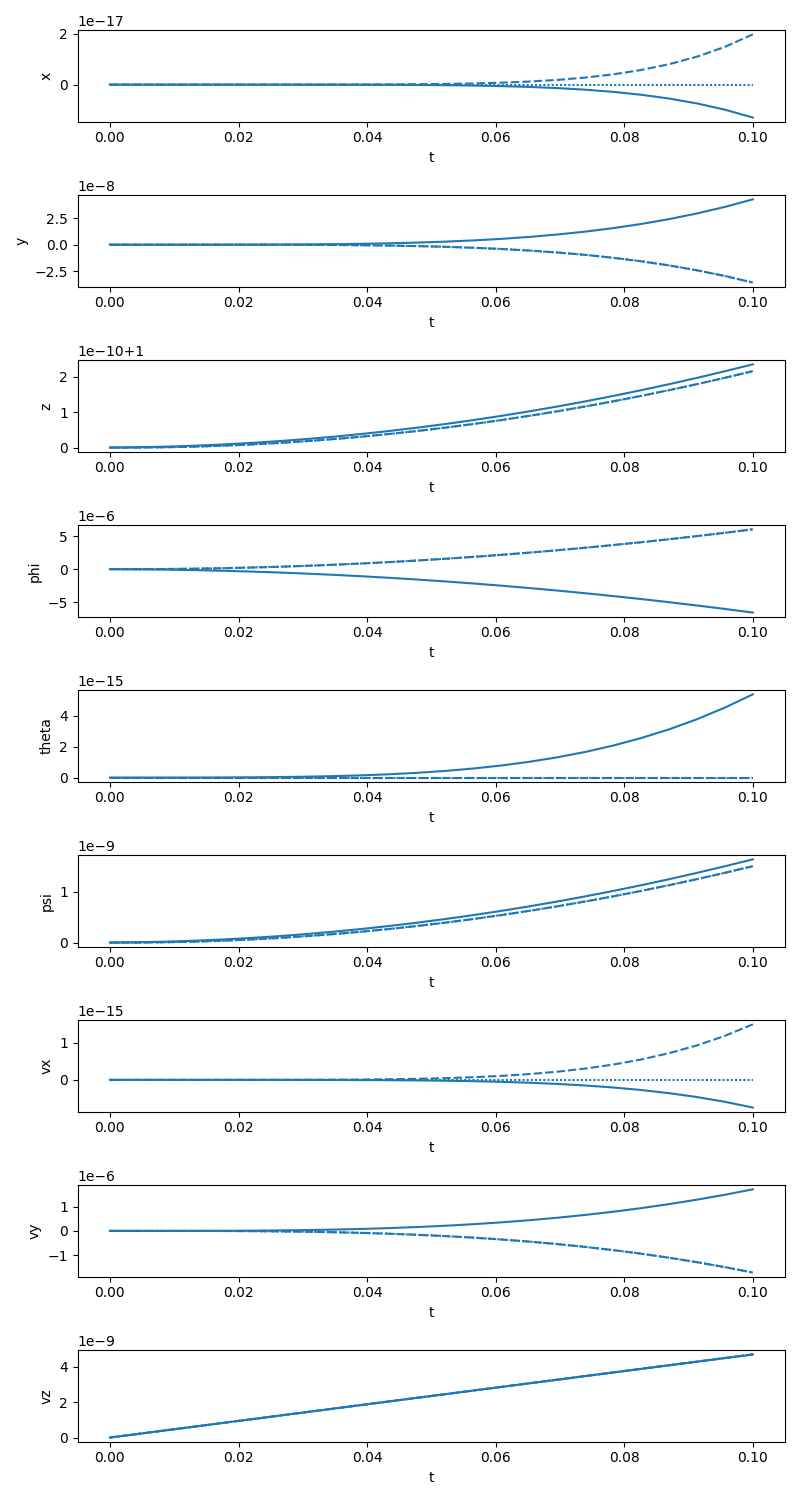

In [8]:
T = 0.1
u = np.tile(np.array((1,0.9999,1,1.0001))*np.sqrt(9.81*1.4/(0.1*4)),(int(T/dt),1))
out = run_envs(u)
plot_data(out)

## Pitch Input

<IPython.core.display.Javascript object>


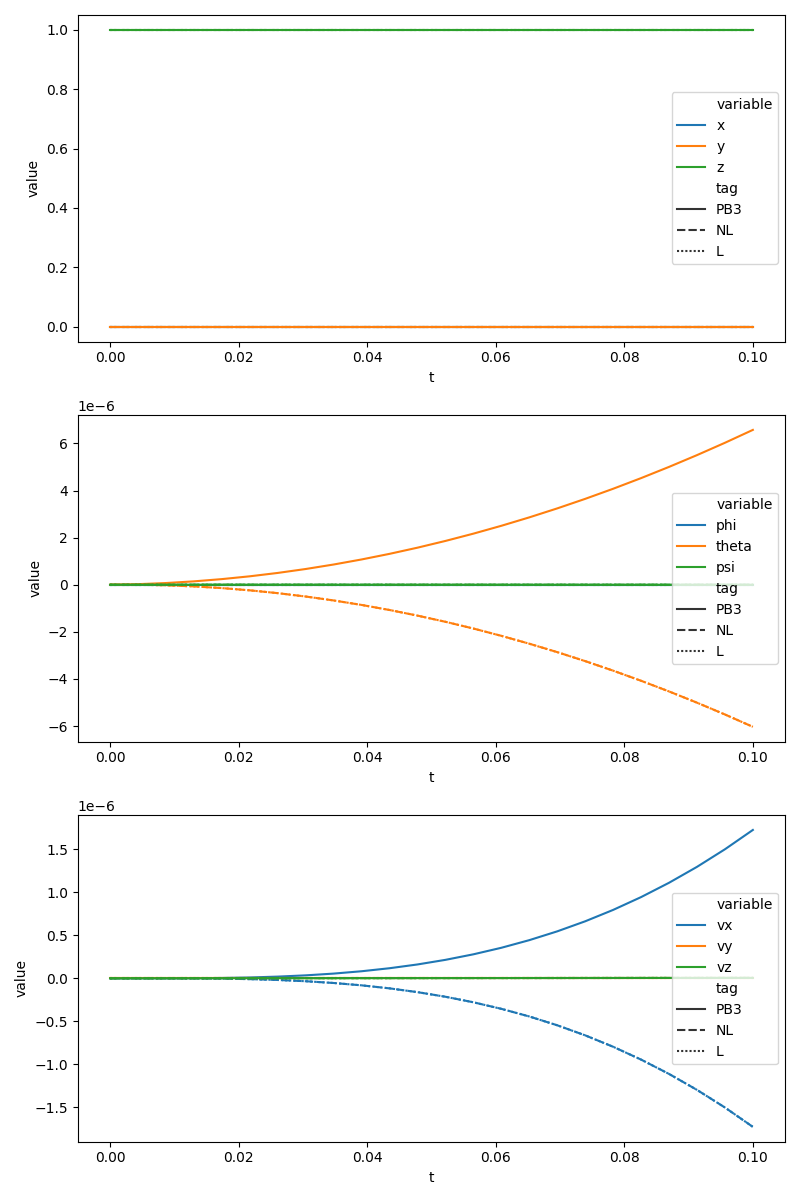

<IPython.core.display.Javascript object>


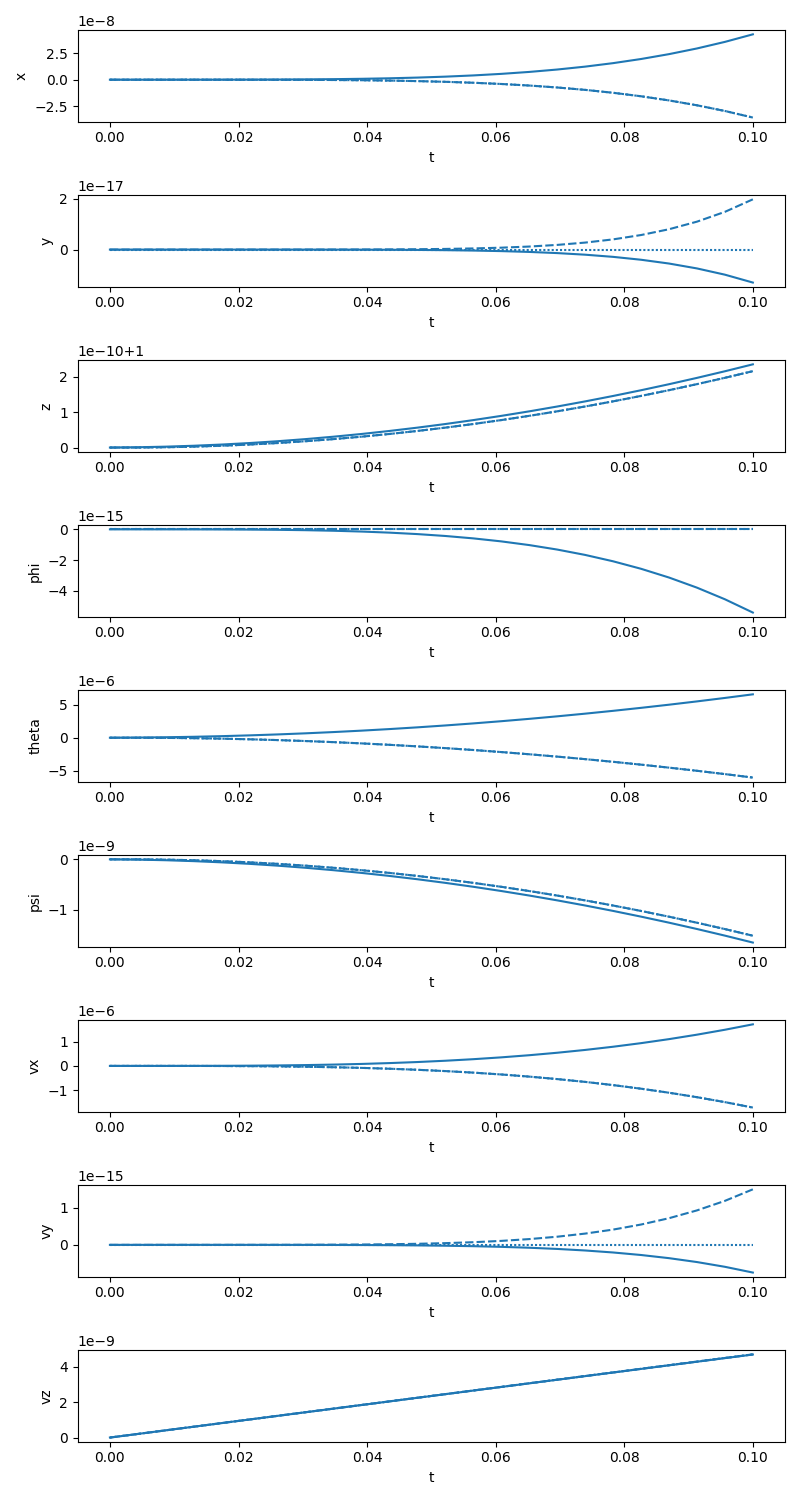

In [9]:
T = 0.1
u = np.tile(np.array((0.9999,1,1.0001,1))*np.sqrt(9.81*1.4/(0.1*4)),(int(T/dt),1))
out = run_envs(u)
plot_data(out)

## Yaw Input

<IPython.core.display.Javascript object>


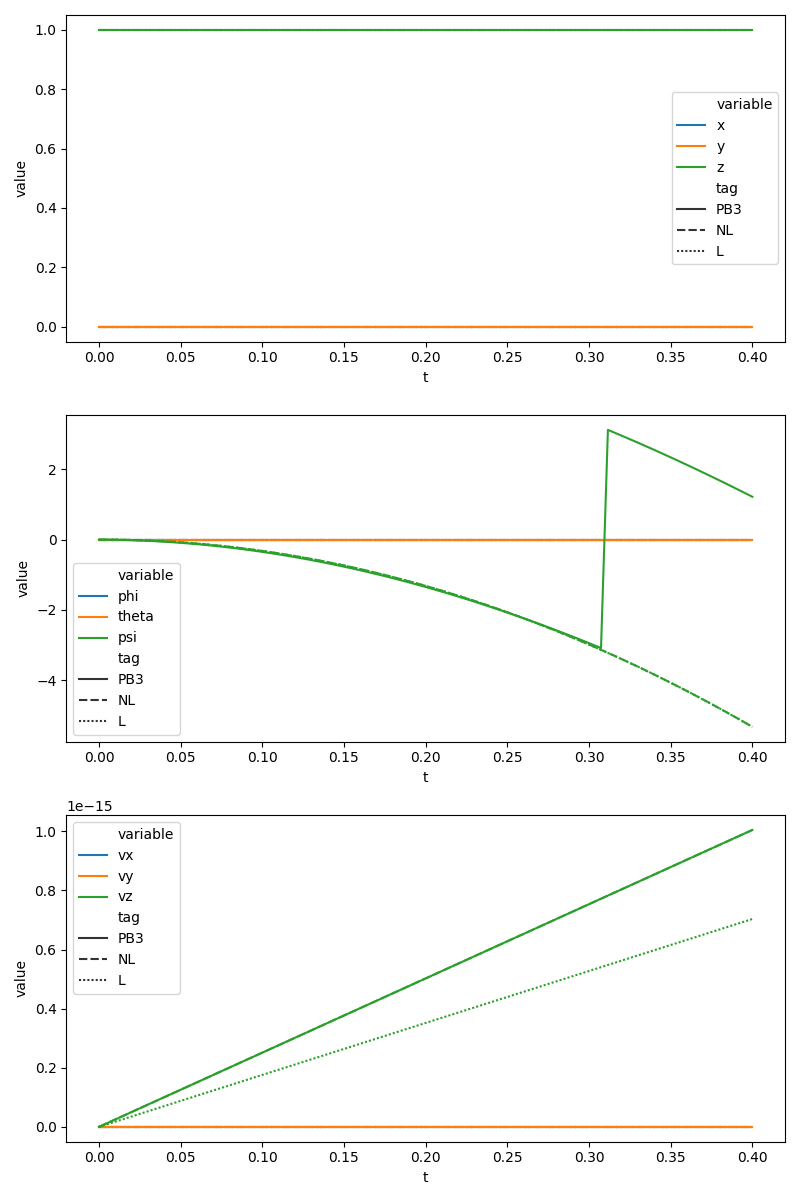

<IPython.core.display.Javascript object>


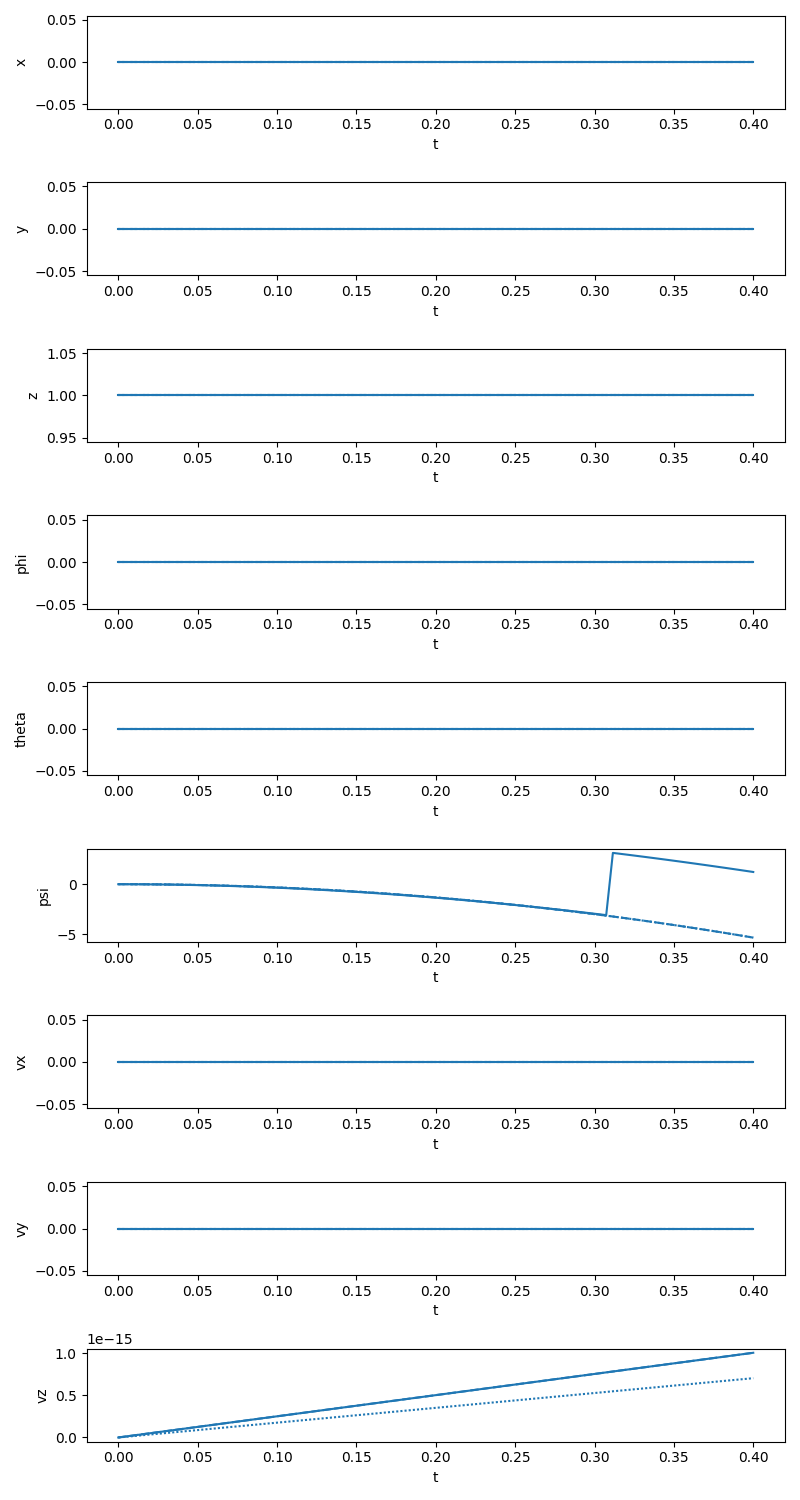

In [10]:
T = 0.4
u = np.tile(np.array((1,0,1,0))*np.sqrt(9.81*1.4/(0.1*2)),(int(T/dt),1))
out = run_envs(u)
plot_data(out)